### **Code for Plotting American Option Binomial Trees** 

In [21]:
import math
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_amer_binomial_option_tree(result_dict):
    """
    Interactive American option tree (Matplotlib).
    Colour-coded nodes show exercise (green) vs hold (red) vs out-of-the-money (grey).
    Includes zoom/pan, axes for time and stock price starting at (0,0).
    """
    price_tree = result_dict["price_tree"]
    option_tree = result_dict["option_tree"]
    N = len(option_tree) - 1
    V0 = option_tree[0][0]  # initial option value
    title = str(N) + "-Step American " + result_dict["option_type"] + " Option Price Tree"
    flags = result_dict["exercise_flags"]

    # --- Set up interactive figure ---
    plt.ioff()  # disable inline static rendering
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title(title, fontsize=13, fontweight="bold")

    # Axis labels
    ax.set_xlabel("Time Step (δt)", fontsize=11)
    ax.set_ylabel("Stock Price (S)", fontsize=11)

    # Start axes at (0, 0)
    ax.set_xlim(-0.5, N + 0.5)
    ax.set_ylim(0, max(max(level) for level in price_tree) * 1.1)

    # --- Plot tree ---
    for i, level in enumerate(price_tree):
        for j, price in enumerate(level):
            x = i
            y = price
            opt_val = option_tree[i][j]
            exercised = flags[i][j]

            # intrinsic value at node (to identify OTM nodes cleanly)
            if result_dict["option_type"].lower() == "call":
                intrinsic = max(price - result_dict.get("E", 0), 0)
            else:
                intrinsic = max(result_dict.get("E", 0) - price, 0)

            # Colour scheme (3 node types)
            if opt_val == 0:
                color = "tomato"          # out-of-the-money / worthless node
            elif exercised:
                color = "seagreen"         # optimal to exercise (early or maturity)
            else:
                color = "royalblue"           # optimal to hold (continue)

            # Branches
            if i < N:
                ax.plot([x, x + 1], [y, price_tree[i + 1][j]], color="gray", linewidth=1)
                ax.plot([x, x + 1], [y, price_tree[i + 1][j + 1]], color="gray", linewidth=1)

            # Node
            label = f"S={price:.2f}\nV={opt_val:.2f}"
            ax.scatter(x, y, s=150, color=color, edgecolor="black", zorder=3)
            ax.text(x, y, label, fontsize=8, ha="center", va="center", color="white",
                    bbox=dict(boxstyle="round,pad=0.3", fc=color, ec="none", alpha=0.9))

    # --- Legend ---
    legend_patches = [
        mpatches.Patch(color="seagreen", label="Exercise (optimal)"),
        mpatches.Patch(color="royalblue", label="Hold (optimal)"),
        mpatches.Patch(color="tomato", label="Worthless (V=0)")
    ]
    ax.legend(handles=legend_patches, loc="upper left", fontsize=8, frameon=False)

    # --- Layout and interactivity ---
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

### **American Option Multi-Step (N-Step) Binomial Model**

In [22]:
def amer_binomial_option_price(S0, E, r, T, u, d, N, option_type="call"):
    """Price an American option using an N-step binomial tree and return exercise flags."""
    import math
    dt = T / N
    p = (math.exp(r * dt) - d) / (u - d)

    opt = option_type.lower()

    # Stock prices at maturity
    prices = [S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]

    # Option payoffs at maturity
    if opt == "call":
        values = [max(price - E, 0) for price in prices]
    else:
        values = [max(E - price, 0) for price in prices]

    option_tree = [values]
    exercise_flags = [[v > 0 for v in values]]  # marks optimal exercise at the node (at maturity: exercise if ITM)

    # Work backwards
    for i in range(N - 1, -1, -1):
        prices = [S0 * (u ** j) * (d ** (i - j)) for j in range(i + 1)]
        new_values = []
        new_flags = []

        for j in range(i + 1):
            cont_val = math.exp(-r * dt) * (p * option_tree[0][j + 1] + (1 - p) * option_tree[0][j])
            if opt == "call":
                exercise_val = max(prices[j] - E, 0)
            else:
                exercise_val = max(E - prices[j], 0)

            # Exercise decision (boundary includes equality: value = gain)
            if exercise_val >= cont_val:
                new_values.append(exercise_val)
                new_flags.append(exercise_val > 0)
            else:
                new_values.append(cont_val)
                new_flags.append(False)

        option_tree.insert(0, new_values)
        exercise_flags.insert(0, new_flags)

    option_tree = [[round(v, 3) for v in level] for level in option_tree]
    price_tree = [[round(S0 * (u**j) * (d**(i - j)),3) for j in range(i + 1)] for i in range(N + 1)]

    return {
        "p": round(p, 5),
        "option_tree": option_tree,
        "option_price": round(option_tree[0][0], 3),
        "price_tree": price_tree,
        "option_type": option_type.capitalize(),
        "exercise_flags": exercise_flags
    }

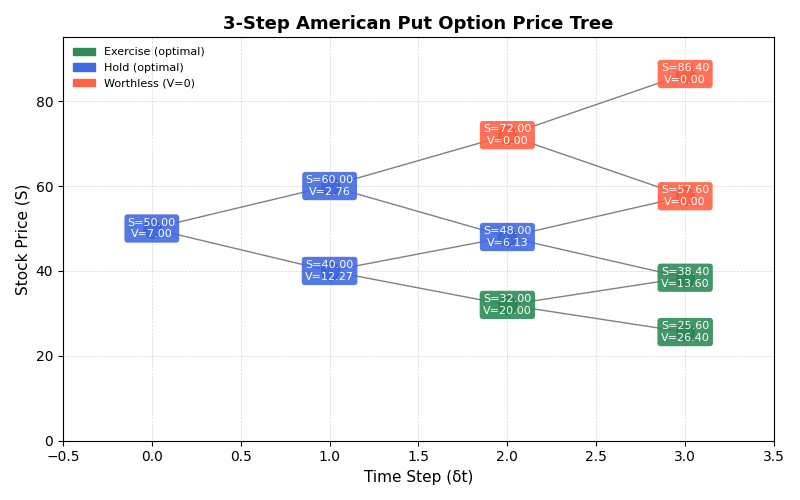

In [23]:
S0, E, r, T, u, d, N , option_type = 50, 52, 0.05, 1, 1.2, 0.8, 3 , "put"
result = (amer_binomial_option_price(S0, E, r, T, u, d, N, option_type))


plot_amer_binomial_option_tree(result)

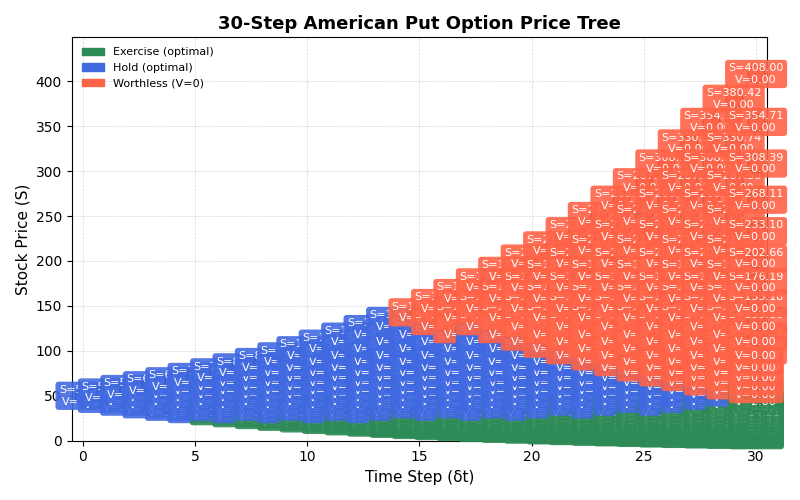

In [24]:
S0, E, r, T, u, d, N , option_type = 50, 52, 0.05, 1, 1.0724808123855336, 0.9324176138645189, 30 , "put"
result = (amer_binomial_option_price(S0, E, r, T, u, d, N, option_type))


plot_amer_binomial_option_tree(result)